# Process Scheduling Simulator

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time 
import boto3 # boto3 library is AWS SDK (software development kit) for python. It lets python program connect to aws services.
import warnings # handling warnings associated with functions having risk of deprecation 
warnings.filterwarnings('ignore') 

## FCFS algorithm function

In [2]:
def fcfs(df): # parameters: dataframe containing process_id, arrival time and burst time
    process=df.copy() 
    process.sort_values(by=["AT","PID"],inplace=True) # processes sorted based on arrival time. 
    # if >=2 process hace same arrival time then secondary sorting interms of process id.
    process["ORDER"]=range(1,len(df)+1) # giving each process an order in which they will get cpu 
    process.set_index("ORDER",inplace=True)
    start_time=0 
    for rank in process.index: 
        if process.at[rank,"AT"]>start_time: # handling edge case when cpu remains idle
            start_time=process.at[rank,"AT"]
        start_time+=process.at[rank,"BT"] # since non pre-emptive, therefore once process gets cpu it will be completely executed
        process.at[rank,"CT"]=start_time 
    process.reset_index(drop=True,inplace=True) # dropping the order column since no longer required
    process["TAT"]=process["CT"]-process["AT"] # TAT = CT - AT 
    process["WT"]=process["TAT"]-process["BT"] # WT = TAT - BT, here I/O time is not considered 
    process["RT"]=process["WT"] # since non pre-emptive, therefore response time = waiting time
    return process # returning the dataframe with necessary process details         

## SJF algorithm function

In [3]:
def sjf(df): # parameters: dataframe containing process_id, arrival time and burst time
    process=df.copy()
    final=df.copy()
    start_time=0
    while len(process)>0: # running a while loop till there are processes in the dataframe
        active=process[process["AT"]<=start_time] # filtering all the processes that have arrivved in ram at the particular starting point
        if active.empty: # handling edge case when cpu remains idle
            start_time=process["AT"].min()
        else:    
            active=active.sort_values(by=["BT","PID"]) # of the arrived processed in ram, sorting is done based on burst time. 
            # if >=2 arrived processes have same burst time, secondary sorting interms of process id
            active.reset_index(drop=True,inplace=True) # by default sorting preserves the inbuilt labels, but these need to be reset for simplicity.
            start_time+=active.at[0,"BT"] # since non pre-emptive, therefore once process gets cpu it will be completely executed
            complete=process[process["PID"]==active.at[0,"PID"]].index # getting the original row label for the completed process 
            final.loc[complete,"CT"]=start_time # adding the completion time of completed process in final dataframe           
            process.drop(complete,axis=0,inplace=True) # removing the completed process from process dataframe
    final["TAT"]=final["CT"]-final["AT"] # TAT = CT - AT 
    final["WT"]=final["TAT"]-final["BT"] # WT = TAT - BT, here I/O time is not considered 
    final["RT"]=final["WT"] # since non pre-emptive, therefore response time = waiting time      
    return final # returning the dataframe with necessary process details   

## SRTF algorithm function

In [4]:
def srtf(df): 
    process=df.copy() 
    final=process.copy()
    pid_l=[]
    pre_l=[]
    post_l=[]
    start_time=0 
    while len(process)>0: # running a while loop till there are processes in the dataframe
        previous_time=start_time 
        active=process[process["AT"]<=start_time] # filtering all the processes that have arrivved in ram at the particular starting point
        if active.empty: # handling edge case when cpu remains idle
            start_time=process["AT"].min() 
            continue
        active=active.sort_values(by=["BT","PID"]) # of the arrived processed in ram, sorting is done based on burst time. 
        # if >=2 arrived processes have same burst time, secondary sorting interms of process id
        active.reset_index(drop=True,inplace=True) # by default sorting preserves the inbuilt labels, but these need to be reset for simplicity.
        upcoming=process[process["AT"]>start_time] # filtering all the processes that will be arriving in ram later
        if (upcoming.empty) or (start_time+active.at[0,"BT"]<=upcoming["AT"].min()): 
            # if upcoming is empty it implies all processes have arrived in ram, therefore it will work as sjf
            # if the earliest upcomming process arrival time greater than start time + burst time for the highest priority arrived process, 
            # then that process will be completely executed without pre-emption 
            start_time+=active.at[0,"BT"] # since non pre-emptive, therefore once process gets cpu it will be completely executed
            complete=process[process["PID"]==active.at[0,"PID"]].index # getting the original row label for the completed process 
            final.loc[complete,"CT"]=start_time # adding the completion time of completed process in final dataframe        
            pid_l.append(active.at[0,"PID"]) # storing the process id of the process
            pre_l.append(previous_time) # storing the start of cpu time
            post_l.append(start_time - previous_time) # storing the duration of cpu time
            process.drop(complete,axis=0,inplace=True) # removing the completed process from process dataframe
        else: # handling the case of pre-emption
            start_time=upcoming["AT"].min() # the highest priority process run uptill the arrival time of earliest upcoming process
            process.loc[process["PID"]==active.at[0,"PID"], "BT"] = active.at[0,"BT"] - (start_time - previous_time) # reducing the burst time
            pid_l.append(active.at[0,"PID"])  # storing the process id of the process
            pre_l.append(previous_time) # storing the start of cpu time
            post_l.append(start_time - previous_time) # storing the duration of cpu time      
    final["TAT"]=final["CT"]-final["AT"] # TAT = CT - AT 
    final["WT"]=final["TAT"]-final["BT"] # WT = TAT - BT, here I/O time is not considered   
    return (final, pid_l, pre_l, post_l) # returning the dataframe with necessary process details along with necessary list needed for charting

## Linux server connection function

In [5]:
def linux_server():
    ssm = boto3.client('ssm', region_name='ap-southeast-2') # telling boto3 to connect to aws using systems session manager
    instance_id = 'i-08c51cdfbb4e61e3f' # storing the instance id of running ec2 server
    pid_command = "ps -eo pid --no-headers" # cli command to return the process ids
    response = ssm.send_command(
        InstanceIds=[instance_id],
        DocumentName="AWS-RunShellScript",
        Parameters={'commands': [pid_command]},
    ) # sending the necessary information and commands via ssm 
    command_id = response['Command']['CommandId']
    time.sleep(2) 
    output = ssm.get_command_invocation(
        CommandId=command_id,
        InstanceId=instance_id,
    )
    stdout = output['StandardOutputContent'].strip().splitlines() # getting the desired ouput of the command
    pids = [line.strip() for line in stdout[:-1]]

    clock_ticks_command = "getconf CLK_TCK" # cli command to measure clock ticks per second, a time unit used by linux kernel to measure process times 
    clock_response = ssm.send_command(
        InstanceIds=[instance_id],
        DocumentName="AWS-RunShellScript",
        Parameters={'commands': [clock_ticks_command]},
    ) # sending the necessary information and commands via ssm 
    time.sleep(1)
    clock_output = ssm.get_command_invocation(
        CommandId=clock_response['Command']['CommandId'],
        InstanceId=instance_id,
    )
    clk_tck = int(clock_output['StandardOutputContent'].strip()) # getting the desired ouput of the command
    
    if len(pids)>50: # to avoid delays due to large number of processes only first 50 processes are considered
        pids=pids[:50]
    process_list = []    
    for pid in pids:
        pid_stat_cmd = f"cat /proc/{pid}/stat" # cli command returns information related to a particular process
        stat_response = ssm.send_command(
            InstanceIds=[instance_id],
            DocumentName="AWS-RunShellScript",
            Parameters={'commands': [pid_stat_cmd]},
        ) # sending the necessary information and commands via ssm 
        time.sleep(0.5)
        stat_output = ssm.get_command_invocation(
            CommandId=stat_response['Command']['CommandId'],
            InstanceId=instance_id,
        )
        stat_fields = stat_output['StandardOutputContent'].split() # getting the desired ouput of the command
        if len(stat_fields) < 22: # handling errors associated with parsing
            continue 
        utime = int(stat_fields[13])
        stime = int(stat_fields[14])
        # utime and stime are different components of cpu execution time measured in clock ticks per second 
        starttime = int(stat_fields[21]) # the time when the process arrived in ram, measured in clock ticks     
        burst_time = (utime + stime) / clk_tck # calculating burst time in seconds 
        if burst_time == 0: # it is assumed that burst time will be greater than 0, hence all 0 burst time processes further removed
            continue
        arrival_time = starttime / clk_tck # calculating arrival time in seconds

        process_list.append({
            "PID": int(pid),
            "AT": arrival_time,
            "BT": burst_time
        })
    df = pd.DataFrame(process_list)
    return df # returning the dataframe with necessary process details   

## Execution script

Welcome to ScheduSim: A Linux-Integrated Process Schedulling Simulator



Enter the schedulling algorithm type [fcfs, sjf, srtf]:  srtf


Enter processeses via linux server or manually (server/manual):  server



       AT    BT    CT   TAT            WT
PID                                      
1    0.13  1.17  1.75  1.62  4.500000e-01
14   0.13  0.08  0.24  0.11  3.000000e-02
15   0.13  0.11  0.35  0.22  1.100000e-01
16   0.13  0.03  0.16  0.03  0.000000e+00
28   0.17  0.15  0.58  0.41  2.600000e-01
39   0.33  0.07  0.43  0.10  3.000000e-02
96   0.39  0.01  0.40  0.01  8.673617e-18

Average TAT: 0.36
Average WT: 0.13
Schedule Length: 1.62
Throughput: 4.32



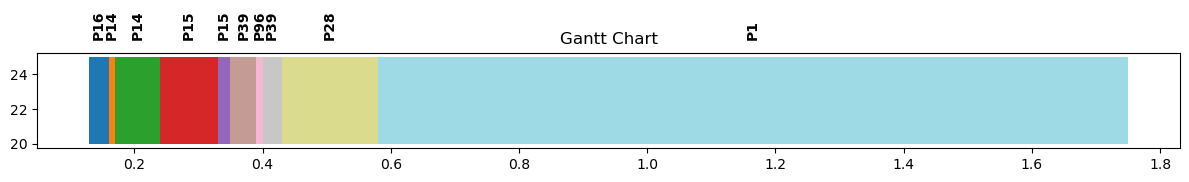

In [9]:
print("Welcome to ScheduSim: A Linux-Integrated Process Schedulling Simulator")
print()
while True:   
    algo=input('Enter the schedulling algorithm type [fcfs, sjf, srtf]: ')
    print()
    choice=input("Enter processeses via linux server or manually (server/manual): ")
    if choice=='server':
        df=linux_server()
    else:    
        count=input("Enter the total number of processes in consideration: ")
        df=pd.DataFrame(columns=["PID","AT","BT"])
        for i in range(int(count)): 
            details=input("Enter the PID, AT, BT in space separated format: ")
            details=details.split()
            df.loc[i]=[details[0],int(details[1]),int(details[2])]   
    print() 
    if algo=="fcfs": 
        output=fcfs(df)
        num_processes = len(output)
        colors = cm.get_cmap('tab20', num_processes).colors
        output["Run_State"]=output["CT"]-output["BT"] 
        # since fcfs is non pre-emptive, therefore start of execution time is measured by completion time - burst time
        fig, ax = plt.subplots(figsize=(12,2)) # plotting of gnatt chart
        for i,j in enumerate(zip(output["PID"],output["Run_State"],output["BT"])):
            ax.broken_barh([(j[1],j[2])],(20,5),facecolors=colors[i]) 
            ax.text(j[1] + j[2]/2, 26, f'P{j[0]}', ha='center', va='bottom', rotation=90, color='black', fontsize=10, fontweight='bold') 
        ax.set_title("Gantt Chart")    
        plt.tight_layout()
        output=output.drop("Run_State",axis=1) # dropping run state column since no longer needed  
        output.set_index("PID",inplace=True)
        print(output) 
        print()
        # measuring key metrics for the algorithm 
        print(f"Average TAT: {round(output["TAT"].sum()/len(output["TAT"]),2)}")
        print(f"Average WT: {round(output["WT"].sum()/len(output["WT"]),2)}")
        print(f"Schedule Length: {round(output["CT"].max()-output["AT"].min(),2)}")
        print(f"Throughput: {round(num_processes/(output["CT"].max()-output["AT"].min()),2)}")
        print()
        break
    elif algo=="sjf": 
        output=sjf(df) 
        num_processes = len(output)
        colors = cm.get_cmap('tab20', num_processes).colors
        output["Run_State"]=output["CT"]-output["BT"] 
        # since sjf is non pre-emptive, therefore start of execution time is measured by completion time - burst time
        fig, ax = plt.subplots(figsize=(12,2)) # plotting of gnatt chart
        for i,j in enumerate(zip(output["PID"],output["Run_State"],output["BT"])):
            ax.broken_barh([(j[1],j[2])],(20,5),facecolors=colors[i]) 
            ax.text(j[1] + j[2]/2, 26, f'P{j[0]}', ha='center', va='bottom', rotation=90, color='black', fontsize=10, fontweight='bold') 
        ax.set_title("Gantt Chart") 
        plt.tight_layout()
        output=output.drop("Run_State",axis=1) # dropping run state column since no longer needed     
        output.set_index("PID",inplace=True)
        print(output)
        print()
        # measuring key metrics for the algorithm 
        print(f"Average TAT: {round(output["TAT"].sum()/len(output["TAT"]),2)}")
        print(f"Average WT: {round(output["WT"].sum()/len(output["WT"]),2)}")
        print(f"Schedule Length: {round(output["CT"].max()-output["AT"].min(),2)}")
        print(f"Throughput: {round(num_processes/(output["CT"].max()-output["AT"].min()),2)}")
        print()
        break
    else: 
        output=srtf(df) 
        num_processes = len(output[1])
        colors = cm.get_cmap('tab20', num_processes).colors
        fig, ax = plt.subplots(figsize=(12,2)) # plotting of gnatt chart 
        for i,j in enumerate(zip(output[1],output[2],output[3])):
            ax.broken_barh([(j[1],j[2])],(20,5),facecolors=colors[int(i)]) 
            ax.text(j[1] + j[2]/2, 26, f'P{j[0]}', ha='center', va='bottom', rotation=90, color='black', fontsize=10, fontweight='bold') 
        ax.set_title("Gantt Chart")   
        plt.tight_layout()
        output[0].set_index("PID",inplace=True)
        print(output[0])
        print()
        # measuring key metrics for the algorithm
        print(f'Average TAT: {round(output[0]["TAT"].sum()/len(output[0]["TAT"]),2)}')
        print(f'Average WT: {round(output[0]["WT"].sum()/len(output[0]["WT"]),2)}')
        print(f'Schedule Length: {round(output[0]["CT"].max()-output[0]["AT"].min(),2)}')
        print(f'Throughput: {round(len(output[0])/(output[0]["CT"].max()-output[0]["AT"].min()),2)}')
        print()
        break